7.256411946745689


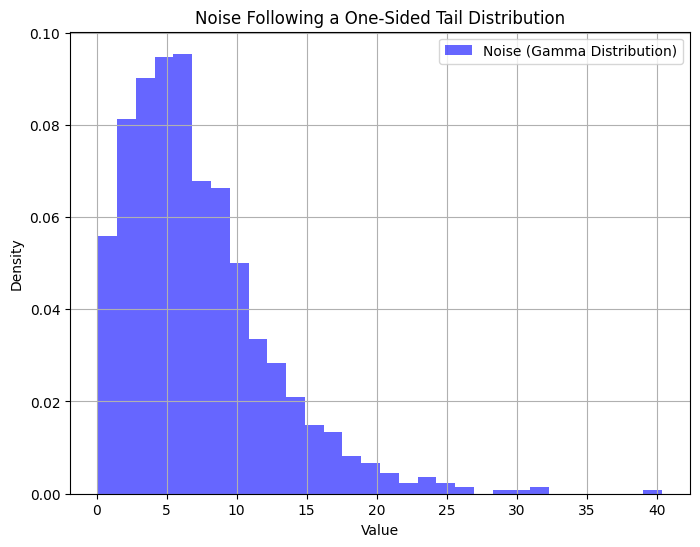

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Set parameters
a = 2  # Shape parameter (adjust to control tail behavior)
desired_mean = 7
scale_gamma = desired_mean / a  # Scale parameter (adjust to control spread)

# Calculate the scale parameter based on the desired mean

num_samples = 1000

# Generate noise following a gamma distribution (one-sided tail)
noise = gamma.rvs(a=a, scale=scale_gamma, size=num_samples)
print(noise.mean())

# Plot the histogram of the noise
plt.figure(figsize=(8, 6))
plt.hist(noise, bins=30, density=True, alpha=0.6, color='blue', label='Noise (Gamma Distribution)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Noise Following a One-Sided Tail Distribution')
plt.legend()
plt.grid(True)
plt.show()

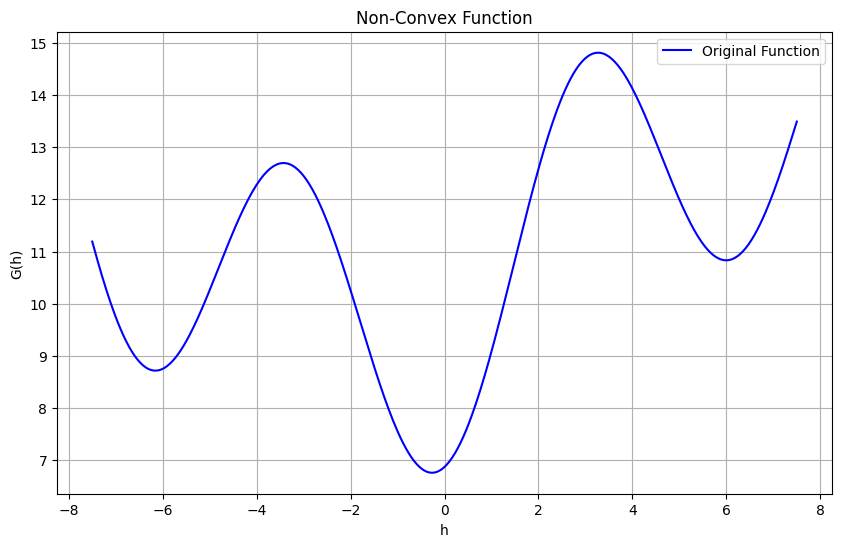

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Define the non-convex function
def non_convex_function(x):
    return (4 * np.sin((x - 3) / 3) + 5 * np.cos(x - 3) + 20) / 1.7


# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Plot the original and noisy functions
plt.figure(figsize=(10, 6))
plt.plot(x, non_convex_function(x), label='Original Function', color='blue')
plt.xlabel('h')
plt.ylabel('G(h)')
plt.title('Non-Convex Function')
plt.legend()
plt.grid(True)
plt.show()

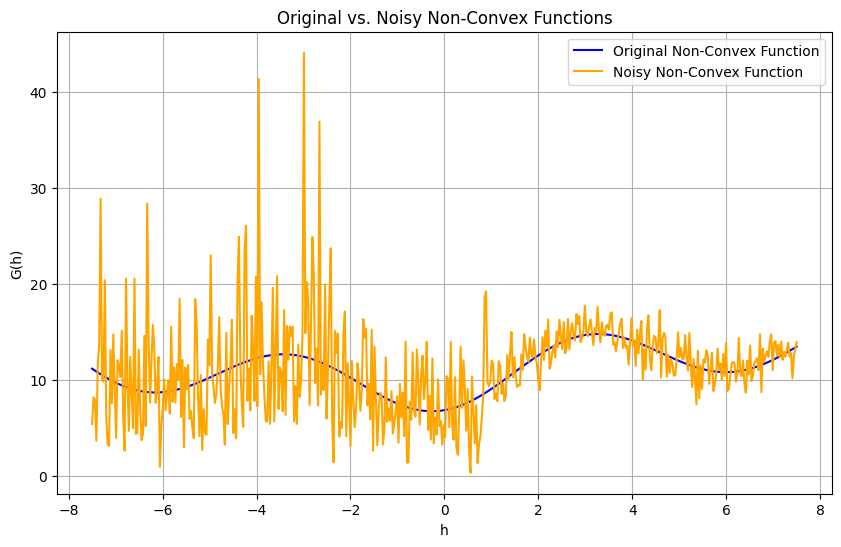

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Define the non-convex function
def non_convex_function(x):
    return (4 * np.sin((x - 3) / 3) + 5 * np.cos(x - 3) + 20) / 1.7

# Define the noisy function values based on the provided code
def non_convex_noisy_function(x):
    # Set parameters for the gamma distribution noise
    a_gamma = 3
    desired_mean = non_convex_function(x)

    # Calculate the scale parameter based on the desired mean
    scale_gamma = desired_mean / a_gamma

    # Set parameters for the normal distribution noise
    mean_normal = 0
    std_normal = 1.8  # Smaller standard deviation for less variance

    if x < 1:
        # Generate noise following a gamma distribution (one-sided tail)
        gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
        noise = gamma_noise
        noisy_function_values = noise
    else:
        # Generate normal noise with less variance for interval [0, 6]
        normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
        noise = normal_noise
        noisy_function_values = non_convex_function(x) + noise
    
    return noisy_function_values

# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Calculate the original non-convex function values
original_function_values = non_convex_function(x)

# Calculate the noisy function values
noisy_function_values = np.array([])
for xi in x:
    # append the noisy function values to the array
    noisy_function_values = np.append(noisy_function_values, non_convex_noisy_function(xi))

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(x, original_function_values, label='Original Non-Convex Function', color='blue')
plt.plot(x, noisy_function_values, label='Noisy Non-Convex Function', color='orange')
plt.xlabel('h')
plt.ylabel('G(h)')
plt.title('Original vs. Noisy Non-Convex Functions')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import optuna
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
import pandas as pd

# spec
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
times = 100
trial = 10
reptition = 2
alpha = 0.5
warm_trials = 1
threshold = 1.5

def _compute_cvar(returns: np.ndarray, alpha: float = 0.2) -> float:
    """ Compute CVaR

    """
    returns = np.array(returns)
    assert returns.ndim == 1, "returns must be 1D array"
    sorted_returns = np.sort(returns)
    n = len(sorted_returns)
    VaR_idx = int(alpha * n)
    if VaR_idx == 0:
        VaR_idx = 1
    
    CVaR = sorted_returns[:VaR_idx].mean()

    return CVaR

def objective(trial, s):
    G = 0
    if s == "naive_single_run":
        h = trial.suggest_float("h", -7.5, 7.5)
        G = non_convex_noisy_function(h)
    elif s == "naive_multiple_runs":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(reptition):
            f.append(non_convex_noisy_function(h))
        G = np.mean(f)
    elif s == "multiple_runs_w/_CVaR":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(reptition):
            f.append(non_convex_noisy_function(h)[0])
        G = _compute_cvar(f, alpha)
    elif s == "dynamics_runs_w/_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(reptition):
                f.append(non_convex_noisy_function(h)[0])
            Gss = _compute_cvar(np.array(f), alpha)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    elif s == "dynamics_runs_w/o_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(reptition):
                f.append(non_convex_noisy_function(h)[0])
            Gss = np.mean(f)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    return G
    

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
df = pd.DataFrame(columns=['Sampler', 'h', 'G', 'Strategy'])
for sampler in samplers:
    for s in strategies:
        for _ in range(times):
            if sampler == "TPESampler":
                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
            elif sampler == "RandomSampler":
                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")

            study.optimize(lambda trial: objective(trial, s), n_trials=trial)
            best_params = study.best_params
            df = df.append({"Sampler": sampler, 
                            "h": best_params["h"], 
                            "G": non_convex_function(best_params["h"]), 
                            "Strategy": s}, ignore_index=True)

/tmp/ipykernel_2312560/1501623953.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Sampler": sampler,
/tmp/ipykernel_2312560/1501623953.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Sampler": sampler,
/tmp/ipykernel_2312560/1501623953.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Sampler": sampler,
/tmp/ipykernel_2312560/1501623953.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Sampler": sampler,
/tmp/ipykernel_2312560/1501623953.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

/tmp/ipykernel_2312560/2513334785.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['Sampler'] == sampler][df['Strategy'] == strategy]['h'],
/tmp/ipykernel_2312560/2513334785.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Sampler'] == sampler][df['Strategy'] == strategy]['G'],


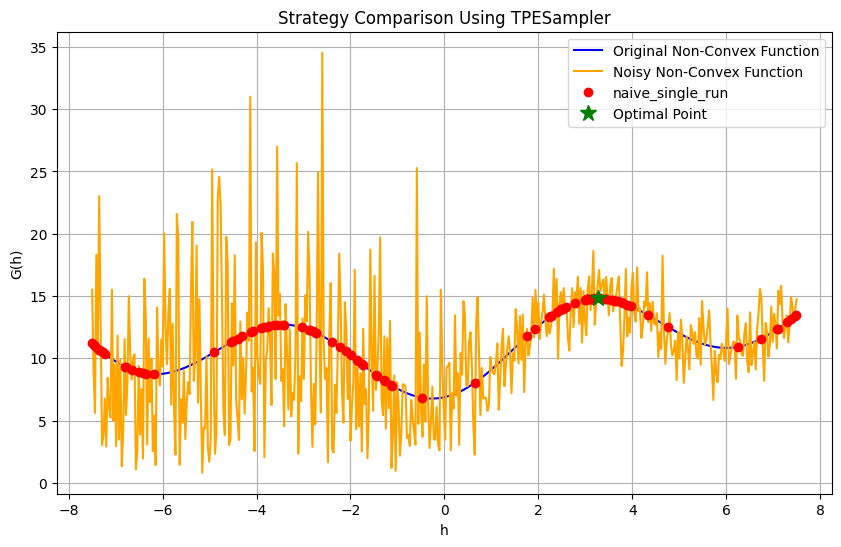

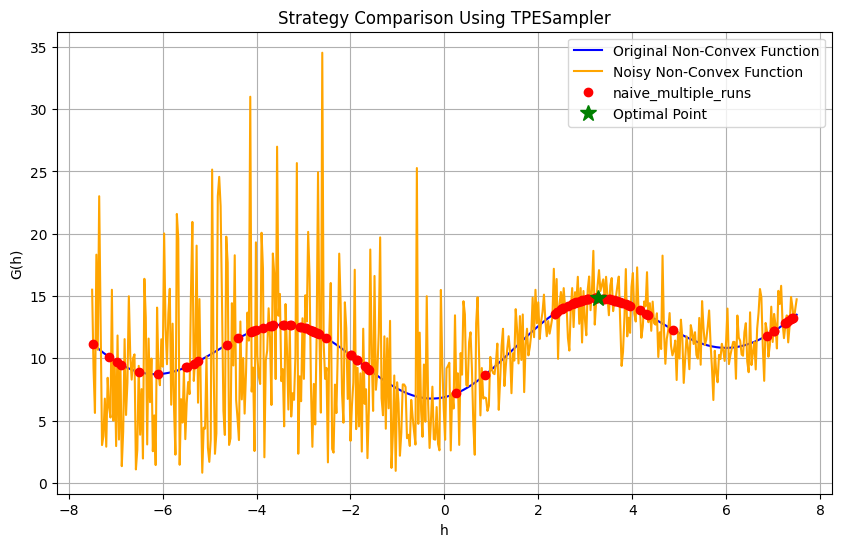

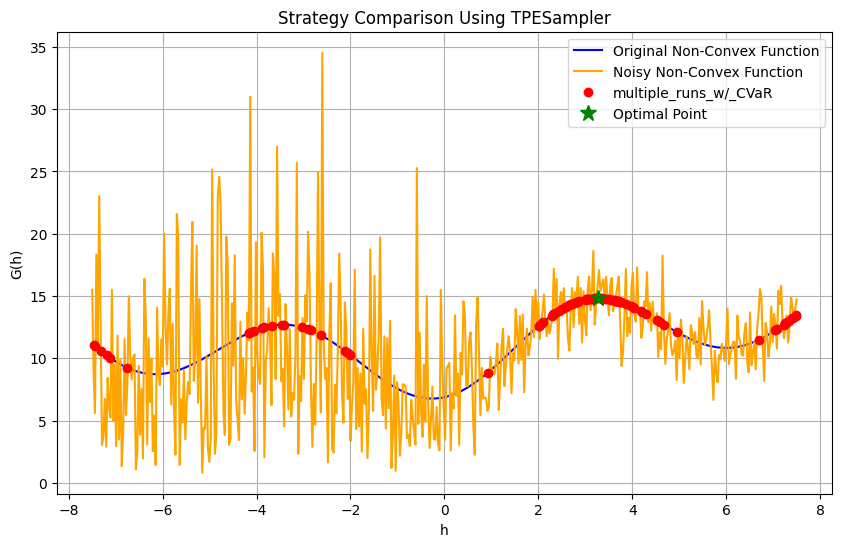

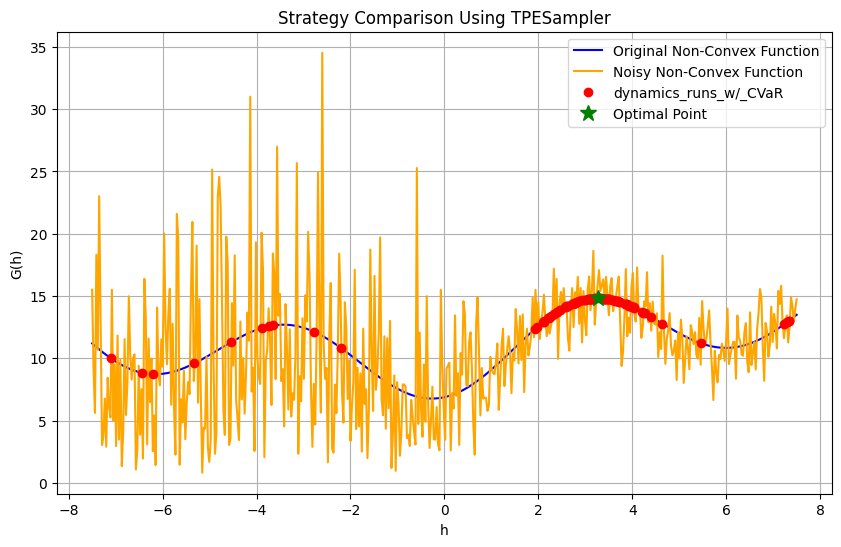

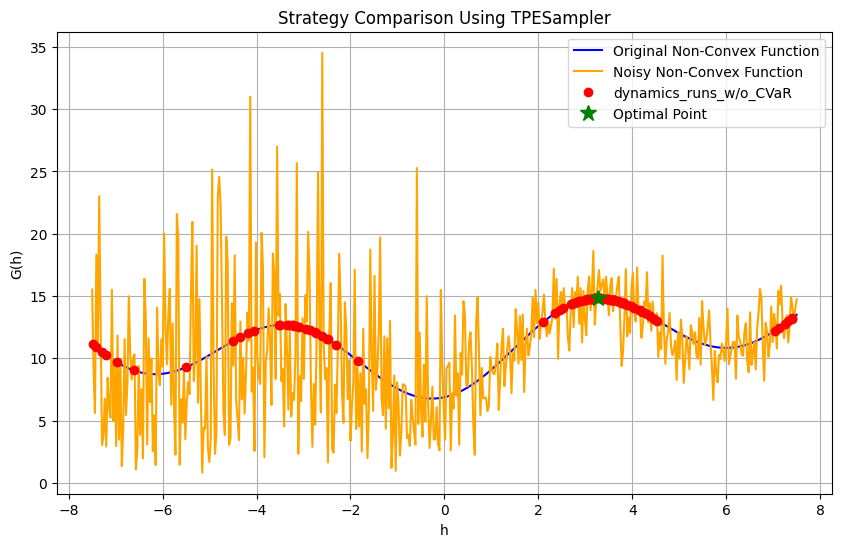

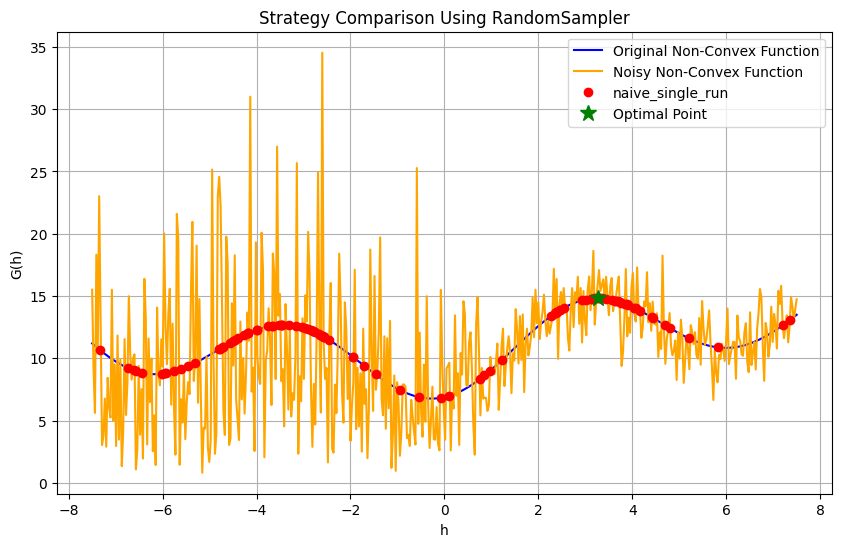

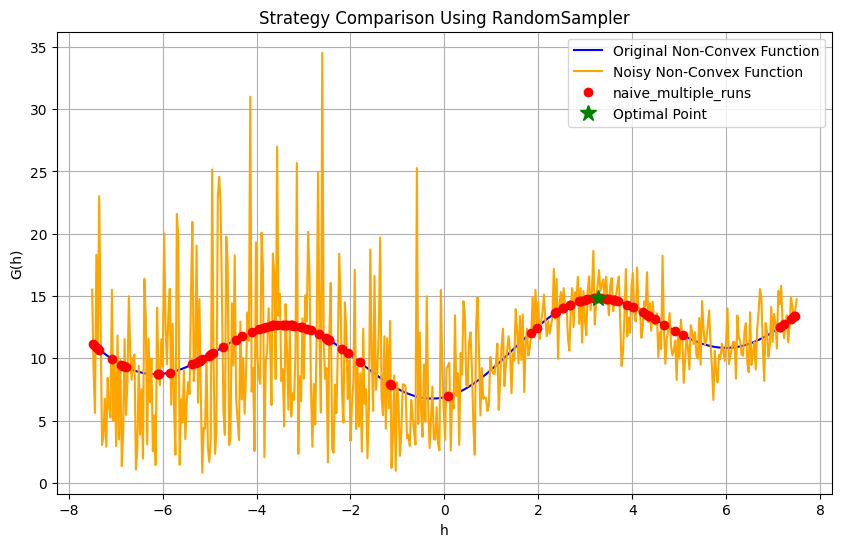

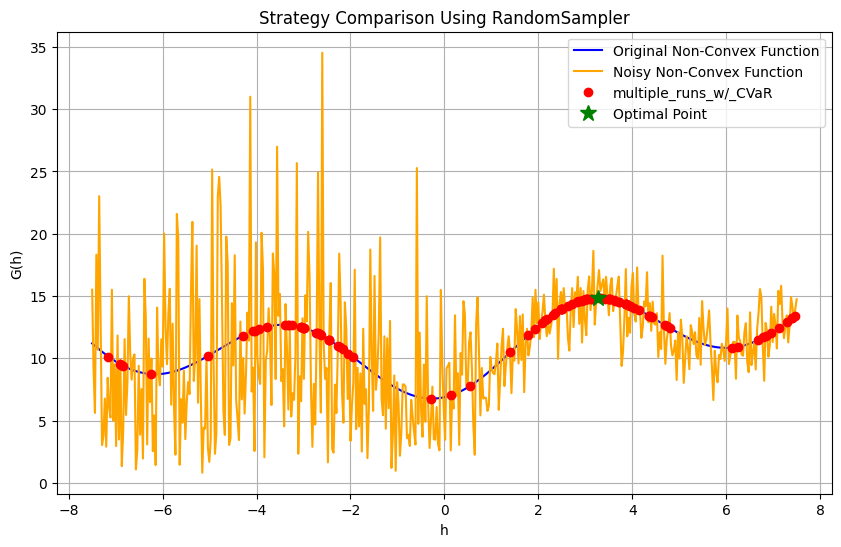

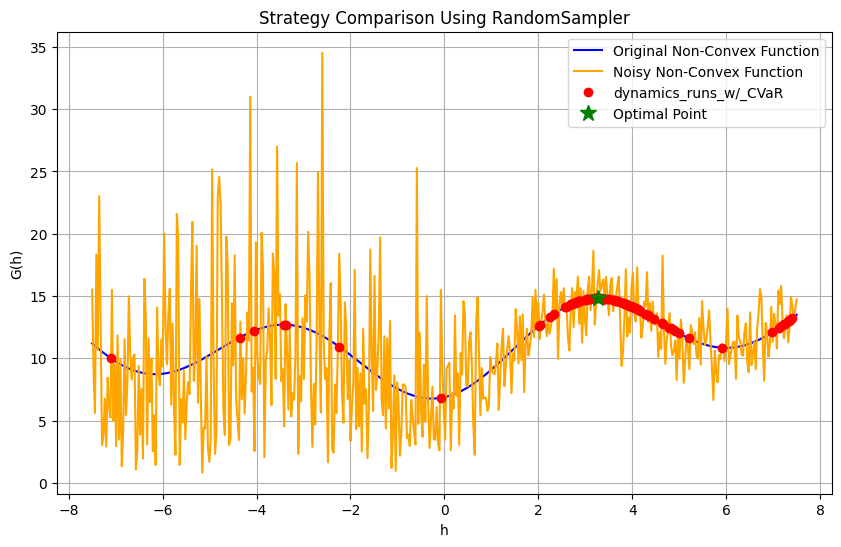

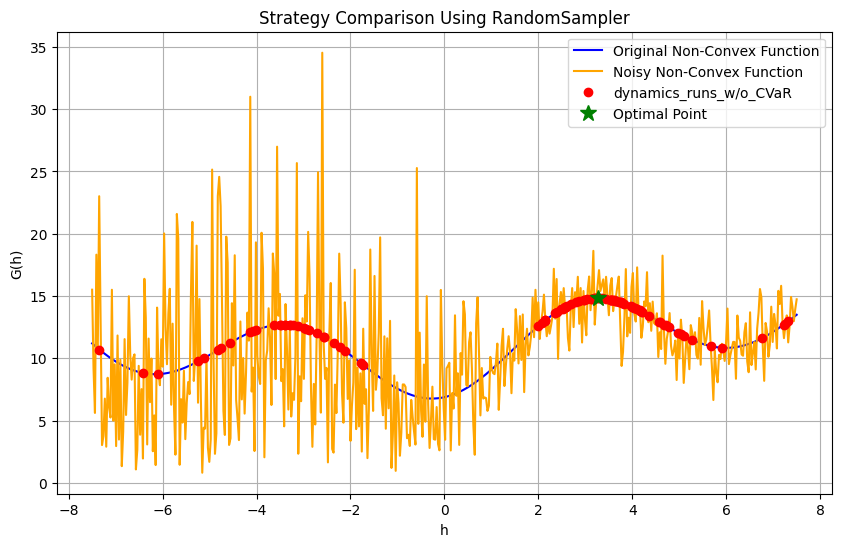

In [21]:
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
# visualize the results
for sampler in samplers:
    for strategy in strategies:
        plt.figure(figsize=(10, 6))
        plt.plot(x, original_function_values, label='Original Non-Convex Function', color='blue')
        plt.plot(x, noisy_function_values, label='Noisy Non-Convex Function', color='orange')
        # plot data points for each strategy
        plt.plot(df[df['Sampler'] == sampler][df['Strategy'] == strategy]['h'], 
                 df[df['Sampler'] == sampler][df['Strategy'] == strategy]['G'],
                 'o', label=strategy, color='red')
        # plot the optimal point from original_function_values in green
        plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                 '*', markersize=12, label="Optimal Point", color='green')
        plt.xlabel('h')
        plt.ylabel('G(h)')
        plt.title('Strategy Comparison Using ' + sampler)
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.close()

In [22]:
# discribe the statistical results of the toy example
df.groupby(['Sampler', 'Strategy']).describe()

h                                \
                                      count      mean       std       min   
Sampler       Strategy                                                      
RandomSampler dynamics_runs_w/_CVaR   100.0  3.451625  2.409552 -7.095577   
              dynamics_runs_w/o_CVaR  100.0  1.460790  3.677571 -7.344215   
              multiple_runs_w/_CVaR   100.0  1.297274  3.842218 -7.153278   
              naive_multiple_runs     100.0 -0.838753  4.372035 -7.485425   
              naive_single_run        100.0 -0.712561  3.886281 -7.335016   
TPESampler    dynamics_runs_w/_CVaR   100.0  2.611337  2.692535 -7.099936   
              dynamics_runs_w/o_CVaR  100.0  1.474295  3.819841 -7.487447   
              multiple_runs_w/_CVaR   100.0  2.017491  3.792644 -7.451543   
              naive_multiple_runs     100.0  0.535585  4.109467 -7.479948   
              naive_single_run        100.0 -0.240864  4.344889 -7.498571   

                                                                              \
                                           25%       50%       75%       max   
Sampler       Strategy                                                         
RandomSampler dynamics_runs_w/_CVaR   2.862928  3.579953  4.126921  7.400309   
              dynamics_runs_w/o_CVaR -2.558422  3.002472  3.864664  7.320611   
              multiple_runs_w/_CVaR  -2.502677  2.671974  3.863025  7.468777   
              naive_multiple_runs    -4.146113 -2.484271  3.247866  7.471462   
              naive_single_run       -3.995621 -2.201464  3.189578  7.349329   
TPESampler    dynamics_runs_w/_CVaR   2.465486  3.111405  3.668339  7.326548   
              dynamics_runs_w/o_CVaR -2.524896  3.153446  3.637894  7.398628   
              multiple_runs_w/_CVaR   2.022345  3.041769  3.730754  7.486954   
              naive_multiple_runs    -3.064113  2.525776  3.502411  7.418341   
              naive_single_run       -3.742104 -0.793583  3.154611  7.496244   

                                          G                                 \
                                      count       mean       std       min   
Sampler       Strategy                                                       
RandomSampler dynamics_runs_w/_CVaR   100.0  13.745274  1.268115  6.824676   
              dynamics_runs_w/o_CVaR  100.0  13.069096  1.545395  8.722333   
              multiple_runs_w/_CVaR   100.0  12.763308  1.813715  6.762452   
              naive_multiple_runs     100.0  12.179893  1.927084  6.945267   
              naive_single_run        100.0  11.971589  2.130540  6.822853   
TPESampler    dynamics_runs_w/_CVaR   100.0  13.822938  1.288904  8.723313   
              dynamics_runs_w/o_CVaR  100.0  13.503182  1.467592  9.028122   
              multiple_runs_w/_CVaR   100.0  13.375651  1.420779  8.854354   
              naive_multiple_runs     100.0  12.749055  1.924863  7.188405   
              naive_single_run        100.0  12.195300  2.175940  6.829699   

                                                                       \
                                            25%        50%        75%   
Sampler       Strategy                                                  
RandomSampler dynamics_runs_w/_CVaR   13.022793  14.308123  14.594371   
              dynamics_runs_w/o_CVaR  12.233628  13.045466  14.490503   
              multiple_runs_w/_CVaR   11.867938  12.881218  14.342940   
              naive_multiple_runs     10.816341  12.518739  13.637254   
              naive_single_run        10.765950  12.259738  13.750397   
TPESampler    dynamics_runs_w/_CVaR   13.341861  14.341269  14.733677   
              dynamics_runs_w/o_CVaR  12.631987  14.232279  14.700563   
              multiple_runs_w/_CVaR   12.605853  13.748448  14.587594   
              naive_multiple_runs     12.028973  12.837519  14.517220   
              naive_single_run        10.664127  12.438733  14.328103   

                                  